In this version of the script, we'll not use differencing, though it is suboptimal. This will also get us familiar of the basic structure of the code, without having to worry about differencing.

Remember that when you difference your data you make it stationary, which is good. But, when you want to make a forecast, you have to undo this differencing, which is not trivial. Now libraries like statsmodels do all that work for you. But because we are now using generic machine learning methods, we'll need to do it ourselves. So in order to introduce only one concept at a time, we'll save differencing for the next script.

In this script we'll test the belief that machine learning can extrapolate well. We already know it can't but it will help us to confirm what we saw before. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [3]:
!curl -O https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  2036  100  2036    0     0   1938      0  0:00:01  0:00:01 --:--:--  1955


In [4]:
df=pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [5]:
df['LogPassengers']=np.log(df['Passengers'])

In [6]:

Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In the following code, we'll learn how to convert a time series into a supervised learning dataset.

In [7]:
# Make supervised dataset
# Let's see if we can use T past values to predict the next value

series=df['LogPassengers'].to_numpy() # Numpy array are little easier to index
T=10 # We set the number of lags.
X=[] # We also create empty lists to store inputs and targets
Y=[]

for t in range(len(series)-T):
    x=series[t:t+T] # This is our input which is of the time series of size T
    X.append(x)
    y=series[t+T] # This is to compute the target which is the next value of the time series
    Y.append(y)
    
# We convert both the inputs and targets to the numpy array, which are easy to index    
X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (134, 10) Y.shape (134,)


In [8]:
# To split our input and targets into train and test
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

In [9]:
# To fit a linear regression
lr=LinearRegression()
lr.fit(Xtrain,Ytrain)
lr.score(Xtrain,Ytrain)

0.9599443783339897

In [10]:
lr.score(Xtest,Ytest)

0.6910953044565593

In [11]:
# Test r square is less which means the model is overfitting to the data

In [12]:
# The next step is to create Boolean Index to index both the train and test set
train_idx=df.index<=train.index[-1]
test_idx=~train_idx

In [13]:
train_idx[:T] = False # first T values are not predictable, because we are using big T lags in our model

In [14]:
# To assign the 1 step forecast to the dataframe
df.loc[train_idx,'LR_1step_train']=lr.predict(Xtrain)
df.loc[test_idx,'LR_1step_test']=lr.predict(Xtest)

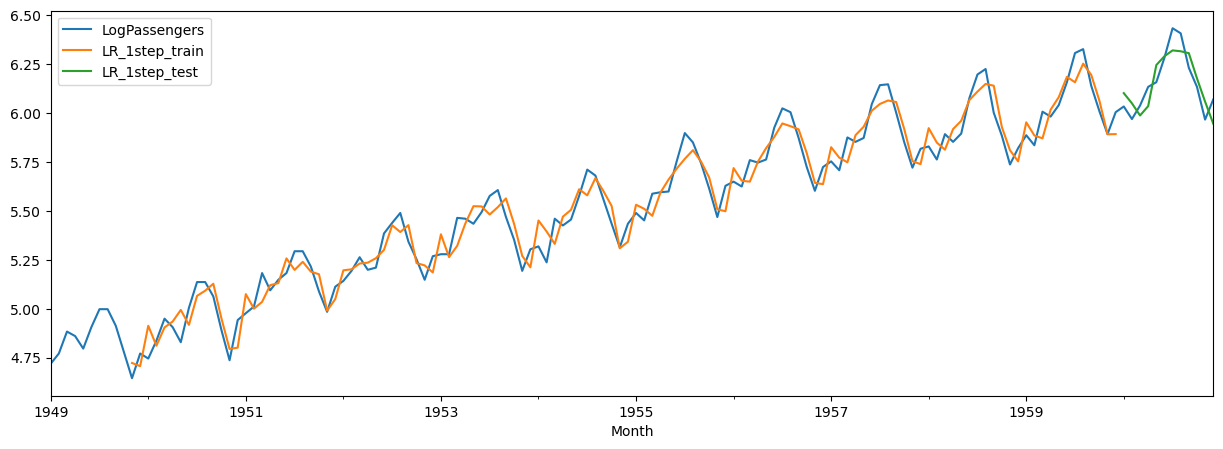

In [15]:
# to plot our 1 step forecast
df[['LogPassengers','LR_1step_train','LR_1step_test']].plot(figsize=(15,5));

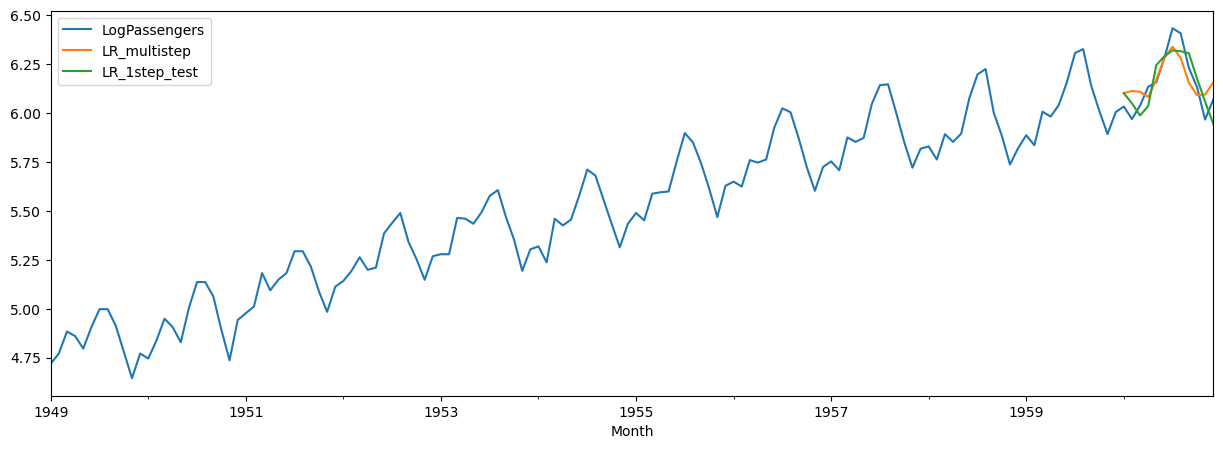

In [16]:
# Notice how our model seems to underestimate peadks
# The next step is to compute multistep forecast
# statsmodels does'nt compute single step forecast, it only computes multistep forecast.
# So this code is closer to what we were doing before when  we were doing ARIMA and ETS

multistep_predictions=[] # empty list to store our predictions

#to obtain the first test input
last_x=Xtest[0]  # This variable will be updated as we go through the loop

while len(multistep_predictions)< Ntest:
    p=lr.predict(last_x.reshape(1,-1))[0] # we have to reshape as scikit learn only accepts 2 d array as input
    # ...continued. Data has to be in the form of a table with samples along the rows and features along the columns.
    # we index the prediction to 0, [0] since there is only one prediction
    
    # update the predictions list
    multistep_predictions.append(p) # to append our prediction to a list of predictions
    
    # make the new input
    last_x=np.roll(last_x,-1) # update last x, basically throw out the oldest value and append the newest value
    last_x[-1]=p
    # First we rotate the values by one step: roll[1,2,3,4,5] -> [2,3,4,5,1] then we assign at -1 
    #...for example we want to assign 6 then the list will become [2,3,4,5,6]
    
    
# save multi-step forecast to dataframe
df.loc[test_idx,'LR_multistep']=multistep_predictions 

# plot 1-step and multi-step forecast
df[['LogPassengers','LR_multistep','LR_1step_test']].plot(figsize=(15,5));
    

In [19]:
# as expected the multistep prediction seems to do worse compared to a one step forecast. 
# Lets create a multi output model
# make multi-output supervised dataset
Tx=T # Number of timesteps in the input
Ty=Ntest # Number of steps in the output
X=[]
Y=[]
for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty] # the loop has a length of Ty
    Y.append(y)
    
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [20]:
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

In [21]:
lr=LinearRegression()
lr.fit(Xtrain_m,Ytrain_m)
lr.score(Xtrain_m,Ytrain_m)

0.9734607773512528

In [24]:
## SST is zero!, so the value of r2 is misleading, SST is the sample variance which is zero for single datapoint
lr.score(Xtest_m,Ytest_m)

C:\Users\asus\anaconda31\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [25]:
r2_score(lr.predict(Xtest_m).flatten(),Ytest_m.flatten())

0.801874967671519

In [26]:
# Save multi-output forecast to dataframe
df.loc[test_idx,'LR_multioutput']=lr.predict(Xtest_m).flatten()

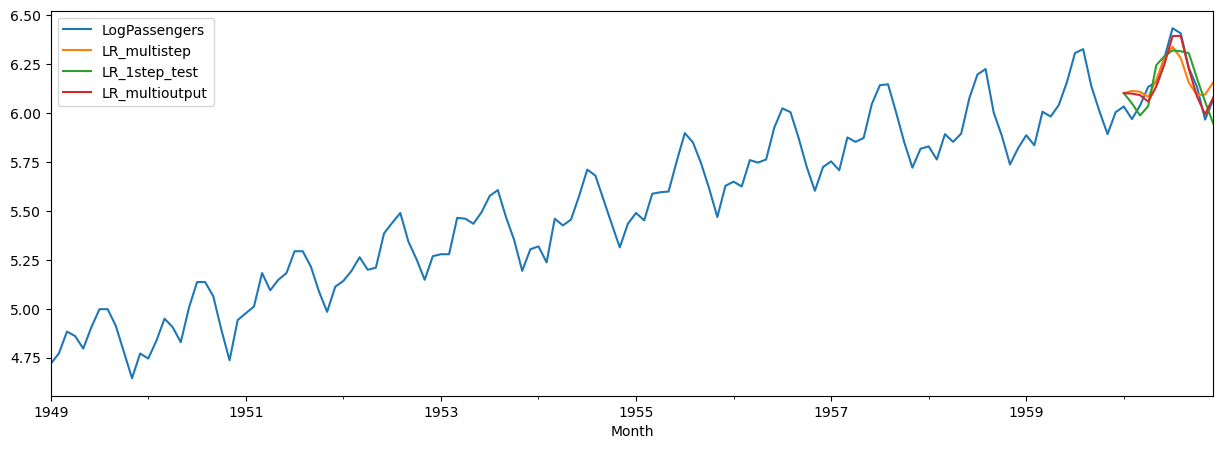

In [27]:
# plot all forecast
cols=['LogPassengers','LR_multistep','LR_1step_test','LR_multioutput']
df[cols].plot(figsize=(15,5));

In [30]:
# MAPE
mape1=mean_absolute_percentage_error(Ytest,multistep_predictions)
print('multi-step MAPE:',mape1)
mape2=mean_absolute_percentage_error(
Ytest,df.loc[test_idx,'LR_multioutput'])
print('multi-output MAPE',mape2)

multi-step MAPE: 0.012229325023475334
multi-output MAPE 0.007178924475039848


# Test Other Models

In [34]:
def one_step_and_multistep_forecast(model,name):
    model.fit(Xtrain,Ytrain)
    print('One-step forecast:',name)
    # print('Train R^2:',model.score(Xtrain,Ytrain))
    # print('Test R^2(1-step):',model.score(Xtest,Ytest))
    
    # store 1-step forecast
    df.loc[train_idx,f'{name}_1step_train']=model.predict(Xtrain)
    df.loc[test_idx,f'{name}_1step_test']=model.predict(Xtest)
    
    # generate multi-step forecast
    multistep_predictions=[]
    
    # first test input
    last_x=Xtest[0]
    
    while len(multistep_predictions)<Ntest:
        p=model.predict(last_x.reshape(1,-1))[0]
        
        #update the prediction list
        multistep_predictions.append(p)
        
        # make the new input
        last_x=np.roll(last_x,-1)
        last_x[-1]=p
        
    # store multi-step forecast
    df.loc[test_idx,f'{name}_multistep_test']=multistep_predictions
    
    #MAPE of multi-step forecast
    mape= mean_absolute_percentage_error(Ytest,multistep_predictions)
    print('Test MAP (multistep):',mape)
    
    #plot 1-step and multistep forecast
    cols=[
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df[cols].plot(figsize=(15,5));
        

One-step forecast: SVR
Test MAP (multistep): 0.017529446164230477


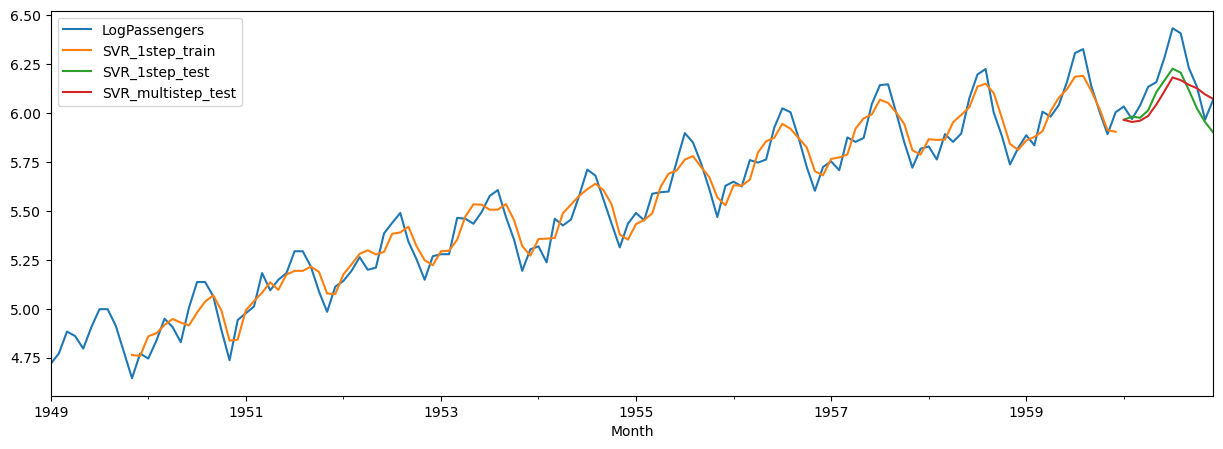

In [35]:
one_step_and_multistep_forecast(SVR(),'SVR')

One-step forecast: RF
Test MAP (multistep): 0.02828641698930265


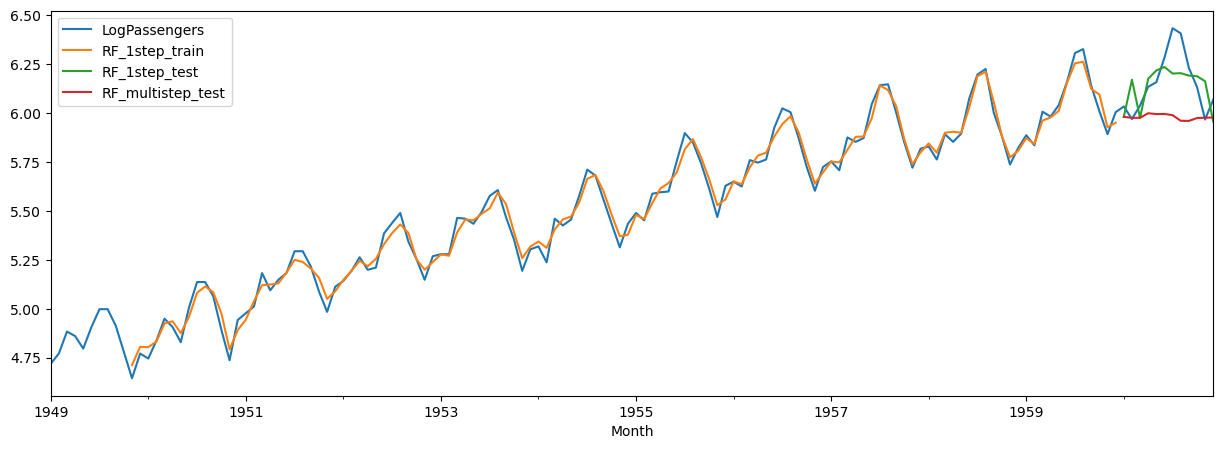

In [36]:
## SVM doesn't peform that well, but this is without differencing
one_step_and_multistep_forecast(RandomForestRegressor(),'RF')

In [38]:
# predictions are pretty bad.
def multi_output_forecast(model,name):
    model.fit(Xtrain_m,Ytrain_m)
    
    # save multioutput forecast to dataframe
    df.loc[test_idx,f'{name}_multioutput']=model.predict(Xtest_m).flatten()
    
    mape=mean_absolute_percentage_error(
    Ytest,df.loc[test_idx,f'{name}_multioutput'])
    print('Test MAPE (multi-output):',mape)
    
    #plot all forecasts
    #assume that previous functions have been run
    cols=[
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput',
    ]
    df[cols].plot(figsize=(15,5));
        

Test MAPE (multi-output): 0.017636325508044354


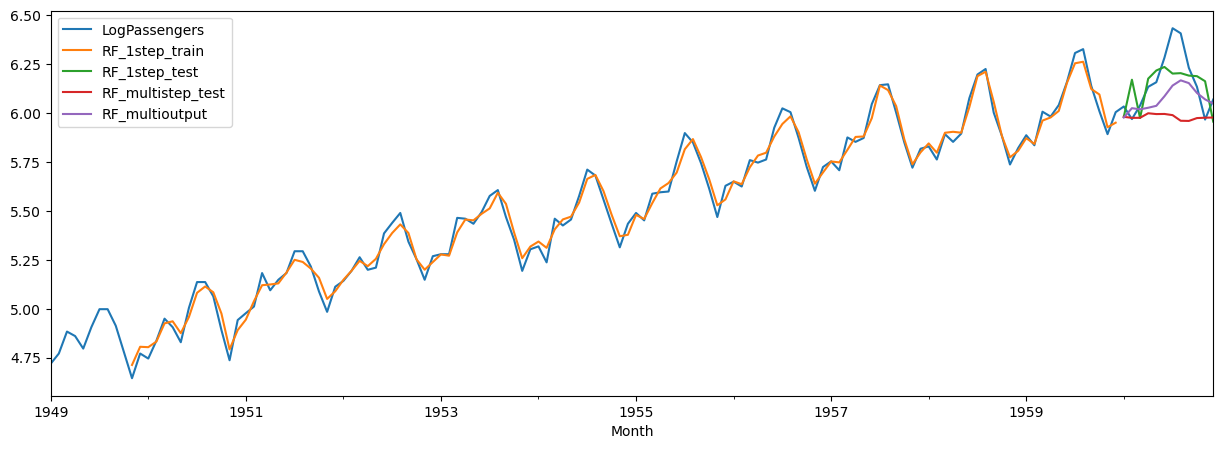

In [39]:
multi_output_forecast(RandomForestRegressor(),'RF')